In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import pickle
from scipy import spatial, sparse
import numpy as np
from numba import cuda
import time
import os

In [8]:
os.chdir('/home/jime/wildfire_GNN')

In [9]:
data = pd.read_csv('~/fires_merged_weather.csv', index_col=0,
                  #dtype for smaller representation
                  dtype={'STAT_CAUSE_DESCR': 'category', 'STATE': 'category', 'DISCOVERY_MONTH': 'category',
                        'Fog': 'bool', 'FunnelCloud': 'bool', 'Hail': 'bool', 'Rain': 'bool',
                        'Snow': 'bool', 'Thunder': 'bool'}
                  )

making doy relative to year, equal to days since 1/1/1992 now

In [10]:
data['DAY'] = (data['FIRE_YEAR']-1992)*365+data['DISCOVERY_DOY']

sort the df

In [11]:
data = data.sort_values(by=['DAY','LATITUDE','LONGITUDE'])

only consider rows within the given time range (need to include lat/lon ranges)

need to use cdist for lat/lon

In [23]:
def simpleA(data,day_cts,geo_dist):
    N = data.shape[0]
    A = sparse.lil_matrix((N,N))
    day = data.iloc[0].DAY 
    row_inc=0
    last_day = data.iloc[-1].DAY 
    lat_long = np.array(data[['LATITUDE','LONGITUDE']].values)
    for i in range(N):
        #if the day has changed, reset incrementor
        if data.iloc[i].DAY != day:
            day = data.iloc[i].DAY
            row_inc=0
            #print(day)
        #edge case 1
        if day>data.iloc[0].DAY :
            yesterday_index = i-row_inc-day_cts.loc[day-1]
        else:
            yesterday_index = 0
        #edge case 2
        if day<(last_day-1):
            tomorrow_index = i-row_inc+day_cts.loc[day]+day_cts.loc[day+1]
        else:
            tomorrow_index = N-1
        #loop over possible entries
        D = spatial.distance.cdist(lat_long[i].reshape(1,-1), lat_long[yesterday_index:tomorrow_index])
        for j in range(len(D[0])):
            if D[0][j]<=geo_dist:
                A[i,yesterday_index+j] = 1
        #increment day-relative row
        row_inc+=1
    A = A.tocsr()
    return A

In [26]:
subset = data[data.FIRE_YEAR == 2015][['DAY','LATITUDE','LONGITUDE']]
Day_Cts = subset.groupby('DAY').agg('count').LATITUDE
start = time.time()
subset_A = simpleA(subset,Day_Cts,1)
end = time.time()
print(end-start)

78.02145481109619


In [31]:
print(str((end-start)*data.shape[0]/subset.shape[0]/60/60)+' hrs')

0.5471079094616501 hrs


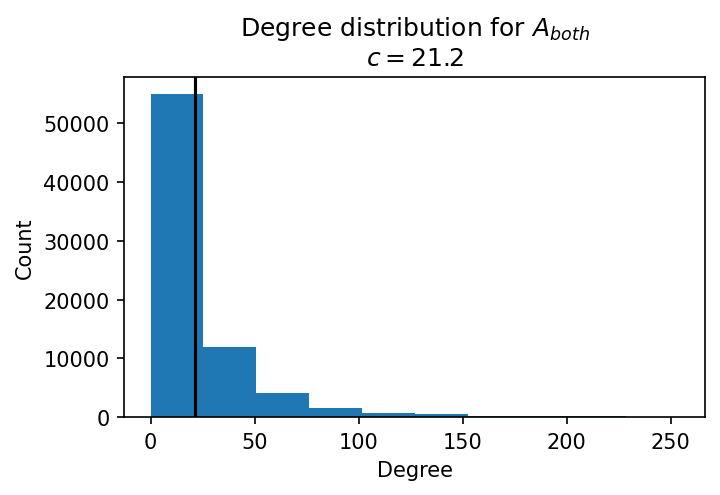

In [42]:
deg = subset_A.sum(axis=1)

fig, ax = plt.subplots(figsize=(5,3), dpi=150)
ax.hist(deg)
ax.set_ylabel("Count")
ax.set_xlabel("Degree")
ax.axvline(x=deg.mean(), ymin=0, ymax=1, color='black')
ax.set_title("Degree distribution for $A_{both}$" + "\n$c={0:.1f}$".format(deg.mean()))
plt.show()

In [41]:
with open('Aboth_simple.pkl', 'wb') as f:
    pickle.dump(subset_A, f)

In [34]:
with open('Aboth.pkl', 'rb') as f:
    old_Aboth = pickle.load(f)

In [35]:
old_Aboth

<74491x74491 sparse matrix of type '<class 'numpy.float64'>'
	with 1247216 stored elements in Compressed Sparse Row format>

In [40]:
subset_A

<74491x74491 sparse matrix of type '<class 'numpy.float64'>'
	with 1580486 stored elements in Compressed Sparse Row format>

need to figure out why this is behaving differently, likely due to the fact that the previous code used DISCOVERY_DOY which only varied between 1 and 365 while this scales DOY to all years